### A. Import dữ liệu cần thiết

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
import re

In [125]:
trending_videos = pd.read_csv('Data/trending_videos.csv', index_col=False)
trending_videos_unique = pd.read_csv('Data/trending_videos_unique.csv', index_col=False)

In [126]:
# pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None

### B. Trực quan hoá

#### 1. Phân tích tổng quan

##### a. Thời điểm đăng trong ngày của video

In [127]:
upload_time = trending_videos_unique[['published_at']].copy()

upload_time['published_at'] = pd.to_datetime(upload_time['published_at'])

upload_time['hour'] = upload_time['published_at'].dt.hour

time_ranges = [f'{i}h - {i+1}h' for i in range(24)]

video_counts = [upload_time[(upload_time['hour'] >= i) & (upload_time['hour'] < i+1)].shape[0] for i in range(24)]

time_video_df = pd.DataFrame({'Time Range': time_ranges, 'Video Count': video_counts})

time_video_df

,Time Range,Video Count
0,0h - 1h,60
1,1h - 2h,32
2,2h - 3h,18
3,3h - 4h,22
4,4h - 5h,34
5,5h - 6h,25
6,6h - 7h,18
7,7h - 8h,18
8,8h - 9h,34
9,9h - 10h,58


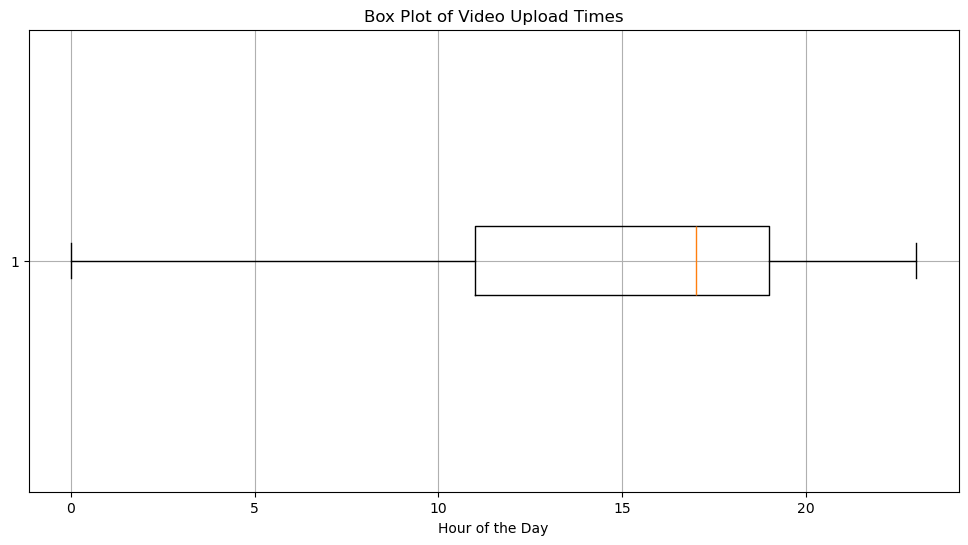

In [128]:
plt.figure(figsize=(12, 6))
plt.boxplot(upload_time['hour'], vert=False)
plt.xlabel('Hour of the Day')
plt.title('Box Plot of Video Upload Times')
plt.grid(True)
plt.show()

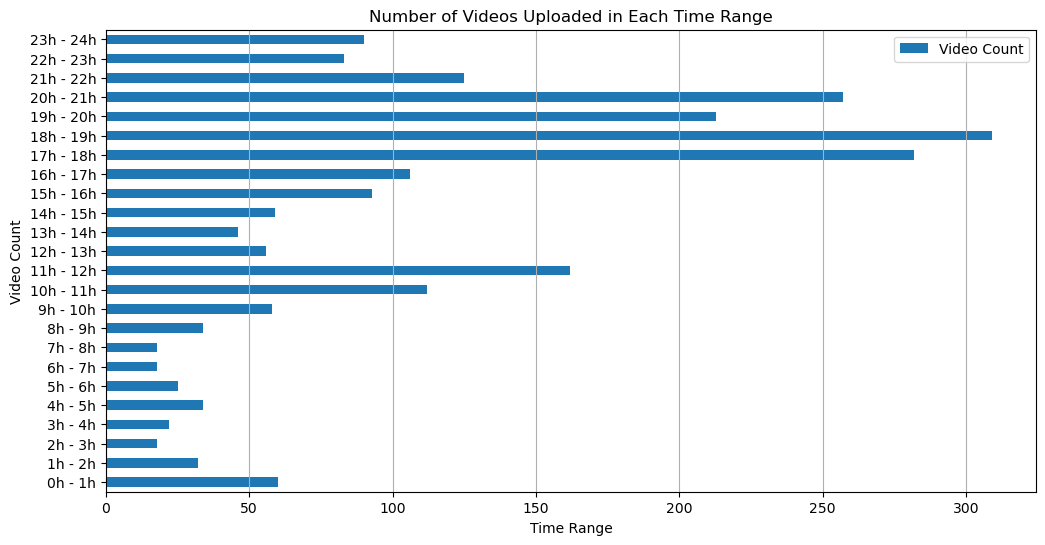

In [129]:
time_video_df.plot(x='Time Range', y='Video Count', kind='barh', figsize=(12, 6))
plt.xlabel('Time Range')
plt.ylabel('Video Count')
plt.title('Number of Videos Uploaded in Each Time Range')
plt.xticks(rotation=0)
plt.grid(True, axis='x')
plt.show()

##### b. Thời gian tồn tại trên trending

In [130]:
time_on_trending = trending_videos_unique[['trending_time']].copy()

time_on_trending = time_on_trending.groupby('trending_time').size().reset_index(name='frequency')

time_on_trending['trending_time'] = pd.to_timedelta(time_on_trending['trending_time'])

time_on_trending = time_on_trending.sort_values(by='trending_time')

time_on_trending

,trending_time,frequency
0,1 days,148
11,2 days,133
18,3 days,153
19,4 days,187
20,5 days,190
21,6 days,200
22,7 days,218
23,8 days,191
24,9 days,159
1,10 days,143


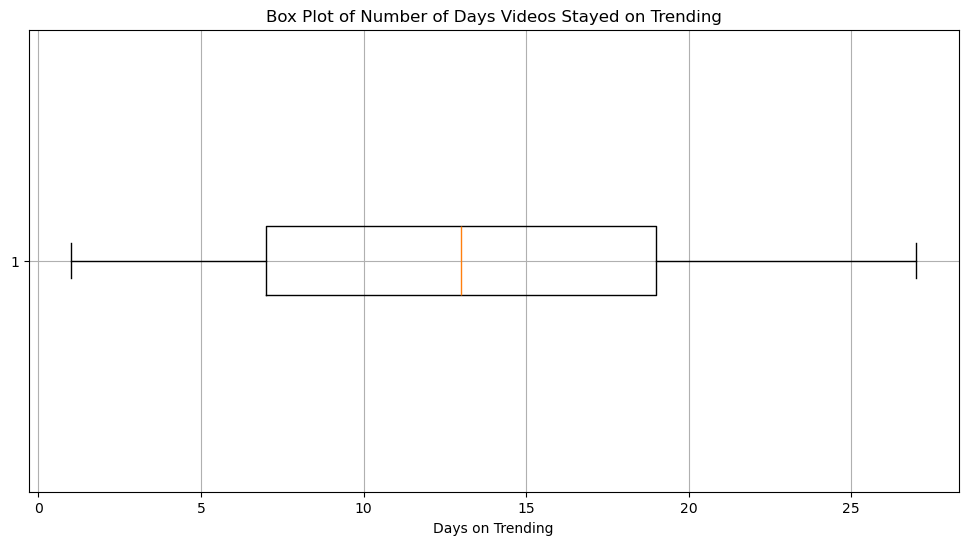

In [131]:
time_on_trending['days_on_trending'] = time_on_trending['trending_time'].dt.days

plt.figure(figsize=(12, 6))
plt.boxplot(time_on_trending['days_on_trending'], vert=False)
plt.xlabel('Days on Trending')
plt.title('Box Plot of Number of Days Videos Stayed on Trending')
plt.grid(True)
plt.show()

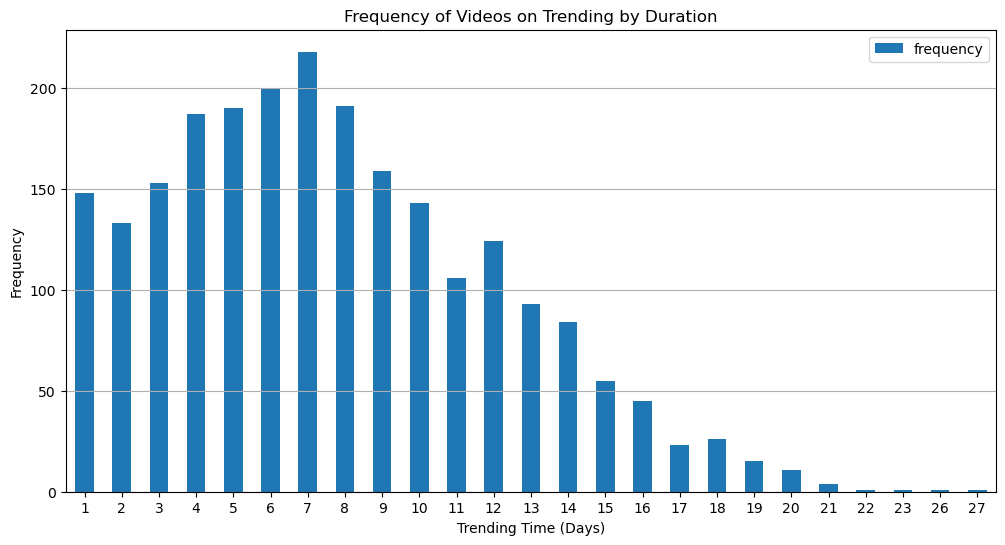

In [132]:
time_on_trending.plot(x='days_on_trending', y='frequency', kind='bar', figsize=(12, 6))
plt.xlabel('Trending Time (Days)')
plt.ylabel('Frequency')
plt.title('Frequency of Videos on Trending by Duration')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.show()

#### 2. Phân tích theo chủ đề

##### a. Phần trăm của từng chủ đề trên trending

In [135]:
category_counts = trending_videos['category'].copy().value_counts()

category_full = category_counts.reset_index()

category_full

,category,count
0,Entertainment,6551
1,People & Blogs,4992
2,Music,1269
3,Gaming,1207
4,Comedy,770
5,Sports,609
6,Howto & Style,538
7,News & Politics,489
8,Film & Animation,432
9,Pets & Animals,271


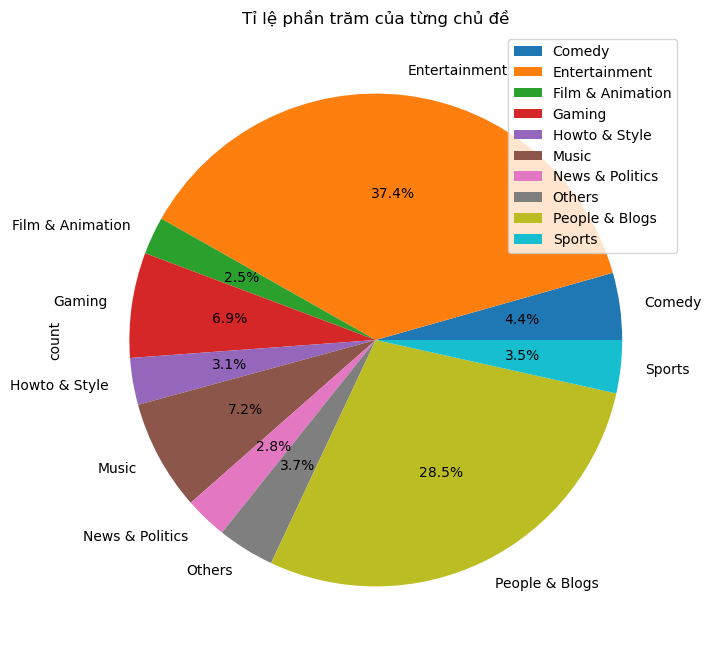

In [137]:
threshold = 400

category_pie = category_full.copy()

category_pie['category'] = category_pie['category'].apply(lambda x: x if category_counts[x] >= threshold else 'Others')

category_pie = category_pie.groupby('category').sum()

category_pie.plot(kind='pie', y='count', autopct='%1.1f%%', figsize=(10, 8))
plt.title('Tỉ lệ phần trăm của từng chủ đề')
plt.show()

##### b. Trung bình lượt tương tác theo chủ đề

In [138]:
pd.options.display.float_format = None

general_category = trending_videos[['category', 'view_count', 'like_count', 'comment_count']]

general_category = general_category.groupby('category').mean().reset_index()

general_category['like_to_view'] = (general_category['like_count'] / general_category['view_count']) * 100

general_category['comment_to_view'] = (general_category['comment_count'] / general_category['view_count'])* 100

general_category

,category,view_count,like_count,comment_count,like_to_view,comment_to_view
0,Autos & Vehicles,3.107792e+06,6.514688e+04,373.597222,2.096243,0.012021
1,Comedy,2.000528e+07,3.692852e+05,885.325974,1.845939,0.004425
2,Education,1.414157e+07,1.423025e+05,689.653846,1.006271,0.004877
3,Entertainment,1.565211e+07,4.495979e+05,5875.157075,2.872443,0.037536
4,Film & Animation,2.598126e+07,1.114053e+06,1956.761574,4.287909,0.007531
5,Gaming,1.139973e+07,4.372097e+05,1862.311516,3.835263,0.016336
6,Howto & Style,3.435267e+07,6.074260e+05,834.693309,1.768206,0.002430
7,Music,1.078366e+07,3.371908e+05,27022.155240,3.126868,0.250584
8,News & Politics,2.137084e+06,3.040098e+04,686.476483,1.422545,0.032122
9,People & Blogs,1.713809e+07,3.889904e+05,1859.762220,2.269742,0.010852


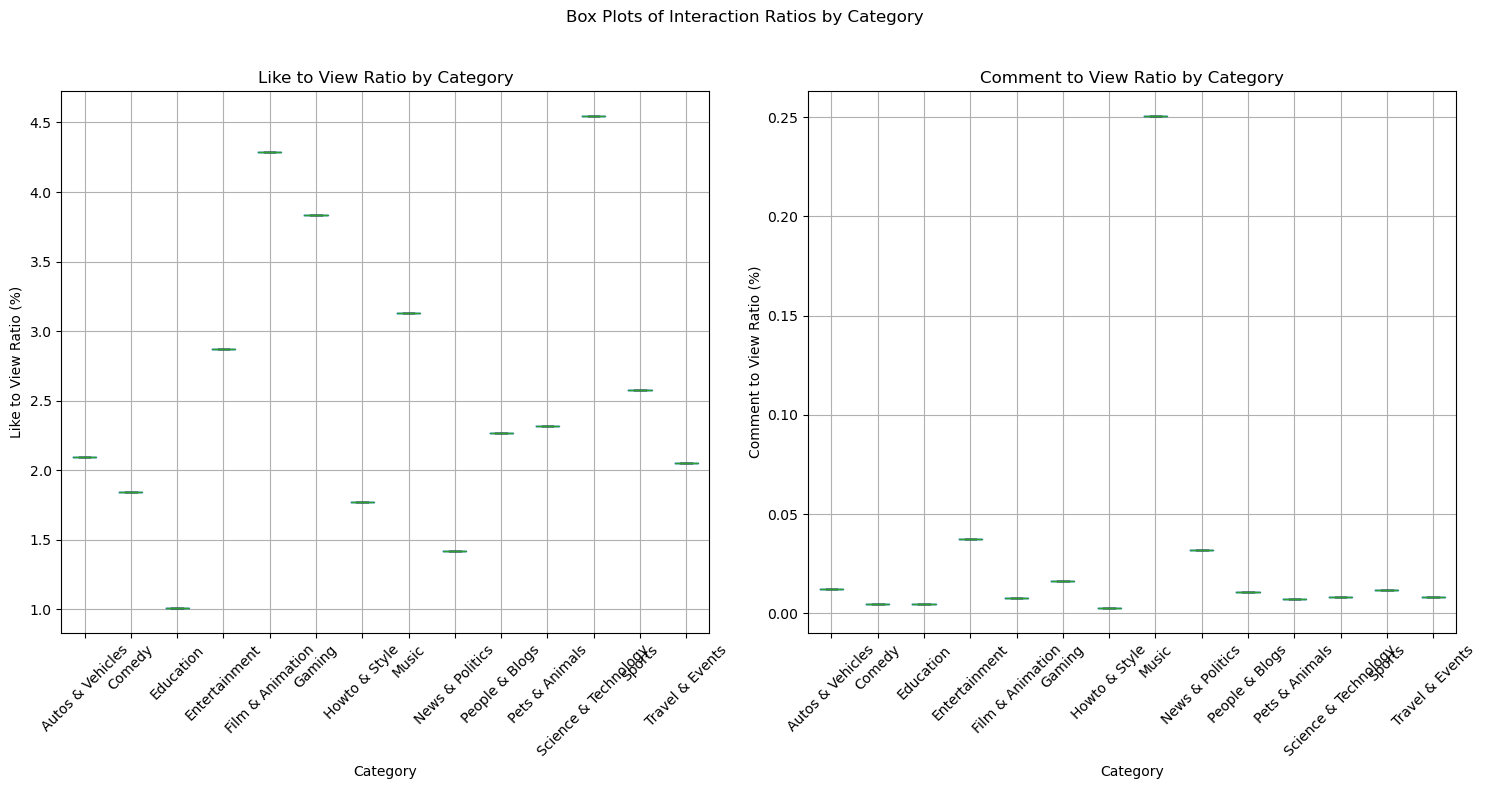

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Box plot for like_to_view ratio
general_category.boxplot(column='like_to_view', by='category', ax=axes[0])
axes[0].set_title('Like to View Ratio by Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Like to View Ratio (%)')
axes[0].tick_params(axis='x', rotation=45)

# Box plot for comment_to_view ratio
general_category.boxplot(column='comment_to_view', by='category', ax=axes[1])
axes[1].set_title('Comment to View Ratio by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Comment to View Ratio (%)')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.suptitle('Box Plots of Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [140]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# # Box plot for like_to_view ratio
# general_category.boxplot(column='like_to_view', by='category', ax=axes[0])
# axes[0].set_title('Like to View Ratio by Category')
# axes[0].set_xlabel('Category')
# axes[0].set_ylabel('Like to View Ratio (%)')
# axes[0].tick_params(axis='x', rotation=45)

# # Box plot for comment_to_view ratio
# general_category.boxplot(column='comment_to_view', by='category', ax=axes[1])
# axes[1].set_title('Comment to View Ratio by Category')
# axes[1].set_xlabel('Category')
# axes[1].set_ylabel('Comment to View Ratio (%)')
# axes[1].tick_params(axis='x', rotation=45)

# # Adjust layout and show plot
# plt.suptitle('Box Plots of Interaction Ratios by Category')
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

##### c. Thời gian trending trung bình của chủ đề

In [141]:
# pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None

trending_category = trending_videos_unique[['category', 'trending_time']].copy()

trending_category['trending_time'] = pd.to_timedelta(trending_category['trending_time'])

trending_category = trending_category.groupby('category').mean()

trending_category = trending_category / np.timedelta64(1, 'h')

trending_category


,trending_time
category,
Autos & Vehicles,219.000000
Comedy,167.357143
Education,212.000000
Entertainment,198.564356
Film & Animation,162.830769
Gaming,150.523077
Howto & Style,170.805195
Music,247.680000
News & Politics,148.148148


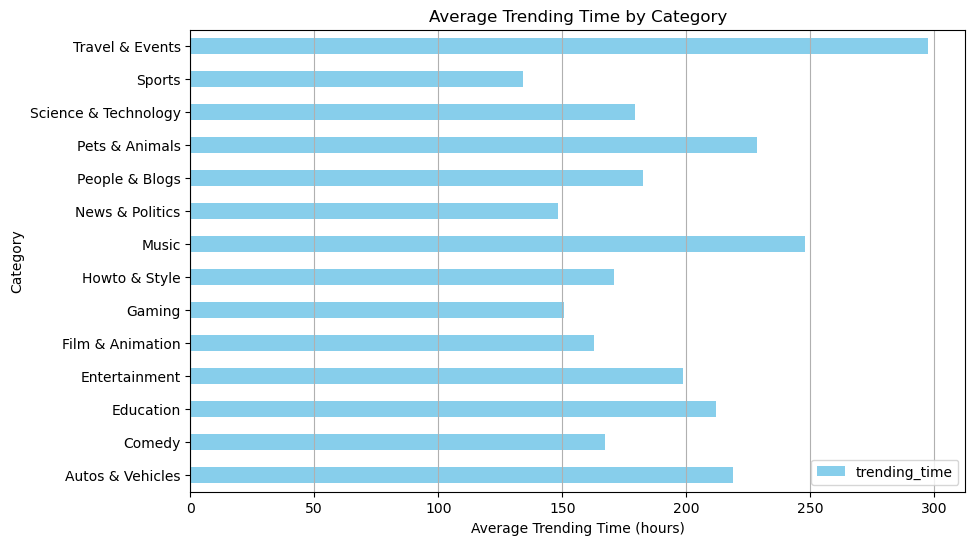

In [142]:
trending_category.plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title('Average Trending Time by Category')
plt.xlabel('Average Trending Time (hours)')
plt.ylabel('Category')
plt.grid(True, axis='x')
plt.xticks(rotation=0)
plt.show()

#### 3. Phân tích theo nội dung chi tiết

##### a. Từ khoá trong tag

In [143]:
video_tags = trending_videos_unique['video_tags'].copy()
video_tags = video_tags.dropna()
tags_list = []
for tagline in video_tags:
    tags_list.extend(tagline.split(','))
count_tags = Counter(tags_list)
tags_df = pd.DataFrame(count_tags.items(),columns=['tag','count'])
tags_df_sort = tags_df.sort_values('count',ascending=False).reset_index(drop=True).head(25)
tags_df_sort

,tag,count
0,shorts,393
1,tiktok,308
2,tik tok,202
3,funny,135
4,hài hước,133
5,tiktok hài hước,119
6,comedy,103
7,giải trí,93
8,hài ngắn,91
9,tiktok việt nam,89


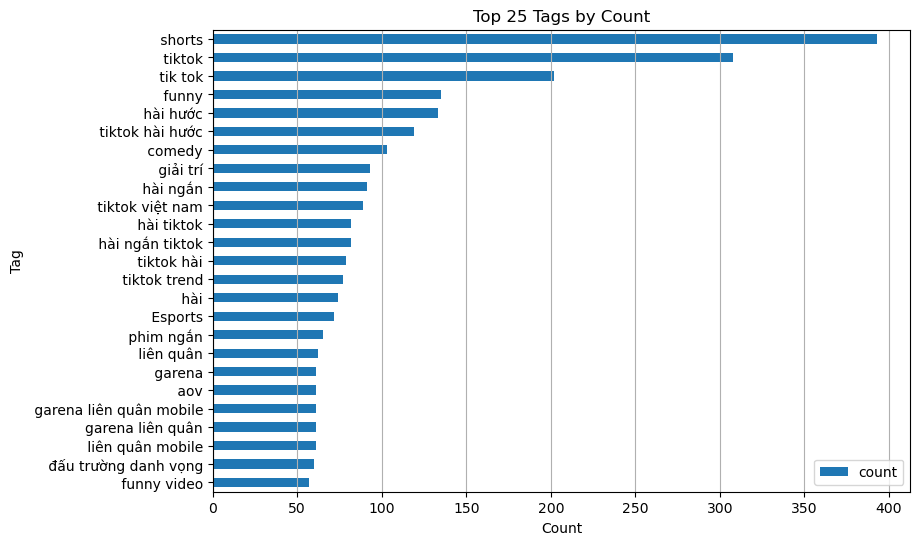

In [144]:
tags_df_sort = tags_df_sort.set_index('tag').sort_values(by='count', ascending=True)
tags_df_sort.plot(kind='barh', figsize=(9, 6))
plt.xlabel('Count')
plt.ylabel('Tag')
plt.title('Top 25 Tags by Count')
plt.grid(True, axis='x')
plt.xticks(rotation=0)
plt.show()

##### b. Độ dài tiêu đề

In [145]:
titles = trending_videos_unique['title'].copy()

def clean_title(title):
    return re.sub(r'[^\w\s]', '', title, flags=re.UNICODE)

def get_len_title(title):
    title = title.strip()
    return len(title.split(' '))

cleaned_title = titles.apply(clean_title)
len_titles = cleaned_title.apply(get_len_title)
count_len = Counter(len_titles)
len_df = pd.DataFrame(count_len.items(),columns=['len','count'])
len_df_to_plot = len_df.set_index('len').sort_values('len',ascending=True)
len_df_to_plot

,count
len,
1,50
2,52
3,75
4,95
5,102
6,111
7,109
8,110
9,144


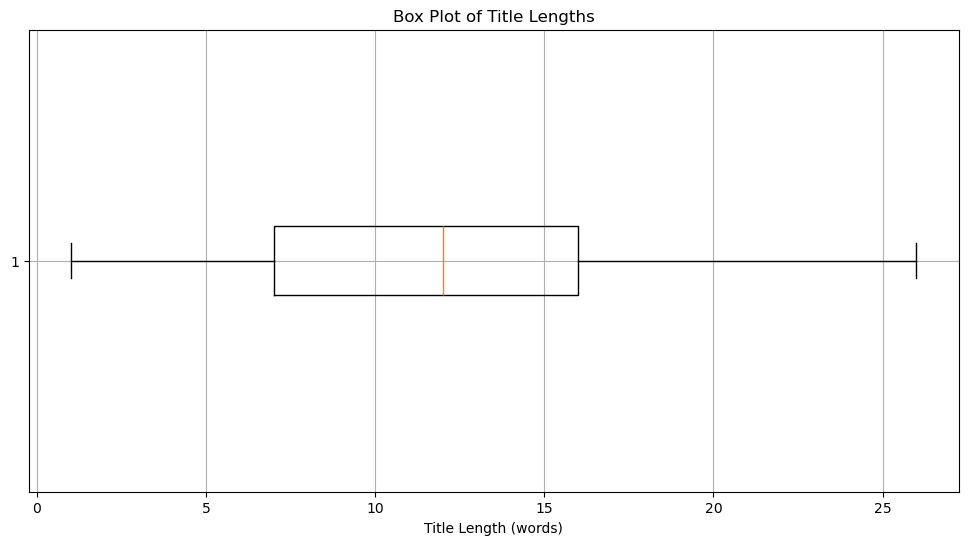

In [146]:
plt.figure(figsize=(12, 6))
plt.boxplot(len_titles, vert=False)
plt.xlabel('Title Length (words)')
plt.title('Box Plot of Title Lengths')
plt.grid(True)
plt.show()

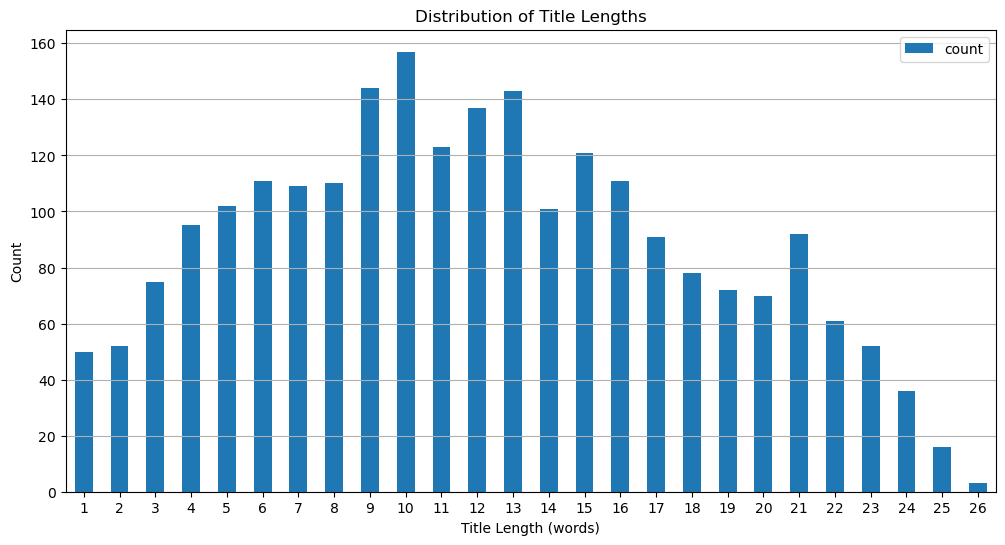

In [147]:
len_df_to_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length (words)')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.show()

#### 4. Phân tích theo thời gian

##### a. Độ dài video theo thời gian

In [148]:
duration_videos = trending_videos[['snapshot_date', 'duration']].copy()

duration_videos['month'] = pd.to_datetime(duration_videos['snapshot_date']).dt.to_period('M')

bins = [pd.Timedelta(minutes=0), pd.Timedelta(minutes=1), pd.Timedelta(minutes=10), pd.Timedelta(minutes=60), pd.Timedelta(hours=24)]

labels = ['<1p', '1-10p', '10-60p', '>60p']

duration_videos['duration_time'] = pd.cut(duration_videos['duration'], bins=bins, labels=labels, right=False)

duration_videos = duration_videos.groupby(['month', 'duration_time'], observed=False).size().unstack(fill_value=0)

duration_videos

duration_time,<1p,1-10p,10-60p,>60p
month,,,,
2023-11,453,424,173,386
2023-12,777,291,146,245
2024-01,847,212,117,216
2024-02,998,196,29,126
2024-03,948,288,56,105
2024-04,1063,223,86,72
2024-05,1191,157,77,107
2024-06,997,256,134,77
2024-07,912,278,53,248


In [149]:
# pd.options.display.float_format = '{:,.0f}'.format
pd.options.display.float_format = None

duration_percentage = duration_videos.div(duration_videos.sum(axis=1), axis=0) * 100

duration_percentage

duration_time,<1p,1-10p,10-60p,>60p
month,,,,
2023-11,31.545961,29.526462,12.047354,26.880223
2023-12,53.255655,19.945168,10.006854,16.792324
2024-01,60.847701,15.229885,8.405172,15.517241
2024-02,73.980726,14.529281,2.149741,9.340252
2024-03,67.859699,20.615605,4.008590,7.516106
2024-04,73.614958,15.443213,5.955679,4.986150
2024-05,77.741514,10.248042,5.026110,6.984334
2024-06,68.101093,17.486339,9.153005,5.259563
2024-07,61.167002,18.645205,3.554661,16.633132


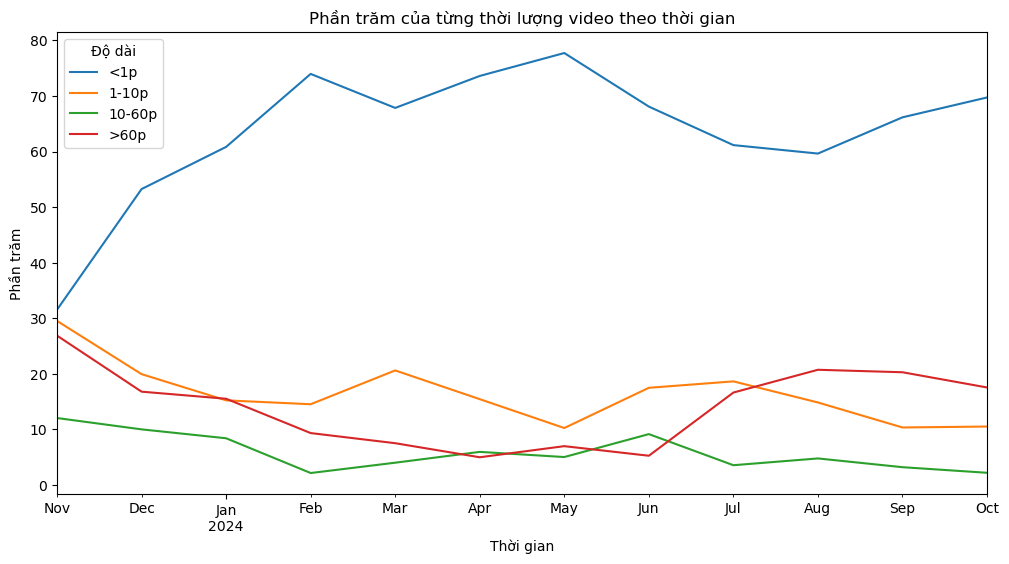

In [150]:
duration_percentage.plot(kind='line', figsize=(12, 6))
plt.title('Phần trăm của từng thời lượng video theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Phần trăm')
plt.legend(title='Độ dài')
plt.show()

##### b. Chủ đề theo thời gian

In [151]:
video_counts = 600

category_area = trending_videos[['snapshot_date', 'category']].copy()

category_area['category'] = category_area['category'].apply(lambda x: x if category_counts[x] >= video_counts else 'Others')

category_area = category_area.groupby(['snapshot_date', 'category']).size().unstack(fill_value=0)

category_area.index = pd.to_datetime(category_area.index)

category_area['month'] = category_area.index.to_period('M')

category_area = category_area.groupby('month').sum()

category_area

category,Comedy,Entertainment,Gaming,Music,Others,People & Blogs,Sports
month,,,,,,,
2023-11,34,572,121,214,138,280,77
2023-12,61,600,115,143,165,351,24
2024-01,114,509,67,84,155,405,58
2024-02,62,507,63,89,154,436,38
2024-03,96,403,134,141,168,421,34
2024-04,67,617,96,13,184,347,120
2024-05,58,556,131,37,217,485,48
2024-06,105,461,59,142,185,412,100
2024-07,51,587,111,93,209,409,31


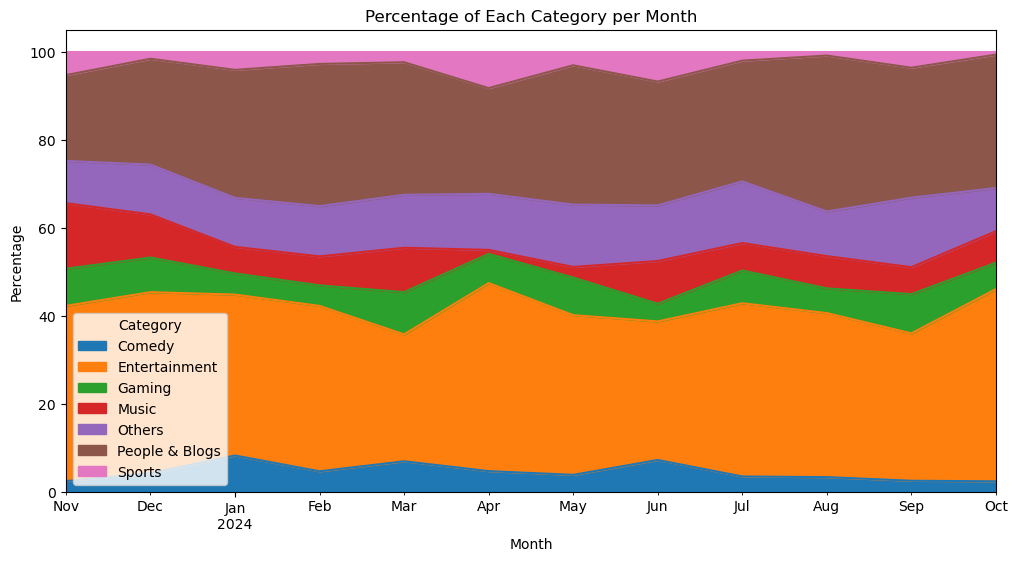

In [152]:
pd.options.display.float_format = None

category_area = category_area.div(category_area.sum(axis=1), axis=0) * 100
category_area.plot(kind='area', figsize=(12, 6))
plt.title('Percentage of Each Category per Month')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(title='Category')
plt.show()

##### c. Trung bình tương tác theo thời gian

In [153]:
pd.options.display.float_format = '{:,.0f}'.format

general_videos = trending_videos[["view_count", "like_count", "comment_count"]].copy()
general_videos.describe()

,view_count,like_count,comment_count
count,"17,512","17,512","17,512"
mean,"16,631,531","440,410","5,097"
std,"29,073,052","1,001,456","22,914"
min,"187,782",0,0
25%,"1,703,761","28,766",135
50%,"3,495,725","63,612",427
75%,"17,990,534","323,578","2,064"
max,"290,801,447","11,040,218","438,822"


In [154]:
general_month = trending_videos[["snapshot_date", "view_count", "like_count", "comment_count"]].copy()

general_month['snapshot_date'] = pd.to_datetime(general_month['snapshot_date'])

general_month['snapshot_date'] = general_month['snapshot_date'].dt.to_period('M')

general_month = general_month.groupby('snapshot_date').mean().reset_index()

general_month

,snapshot_date,view_count,like_count,comment_count
0,2023-11,"7,774,582","209,155","7,430"
1,2023-12,"8,396,831","247,525","3,497"
2,2024-01,"11,770,799","308,438","2,803"
3,2024-02,"16,946,634","421,504","3,429"
4,2024-03,"19,947,261","515,162","6,439"
5,2024-04,"18,610,296","520,917","4,341"
6,2024-05,"22,734,065","600,849","3,302"
7,2024-06,"20,153,998","526,412","6,100"
8,2024-07,"21,877,066","660,230","9,501"
9,2024-08,"16,164,299","434,596","6,374"


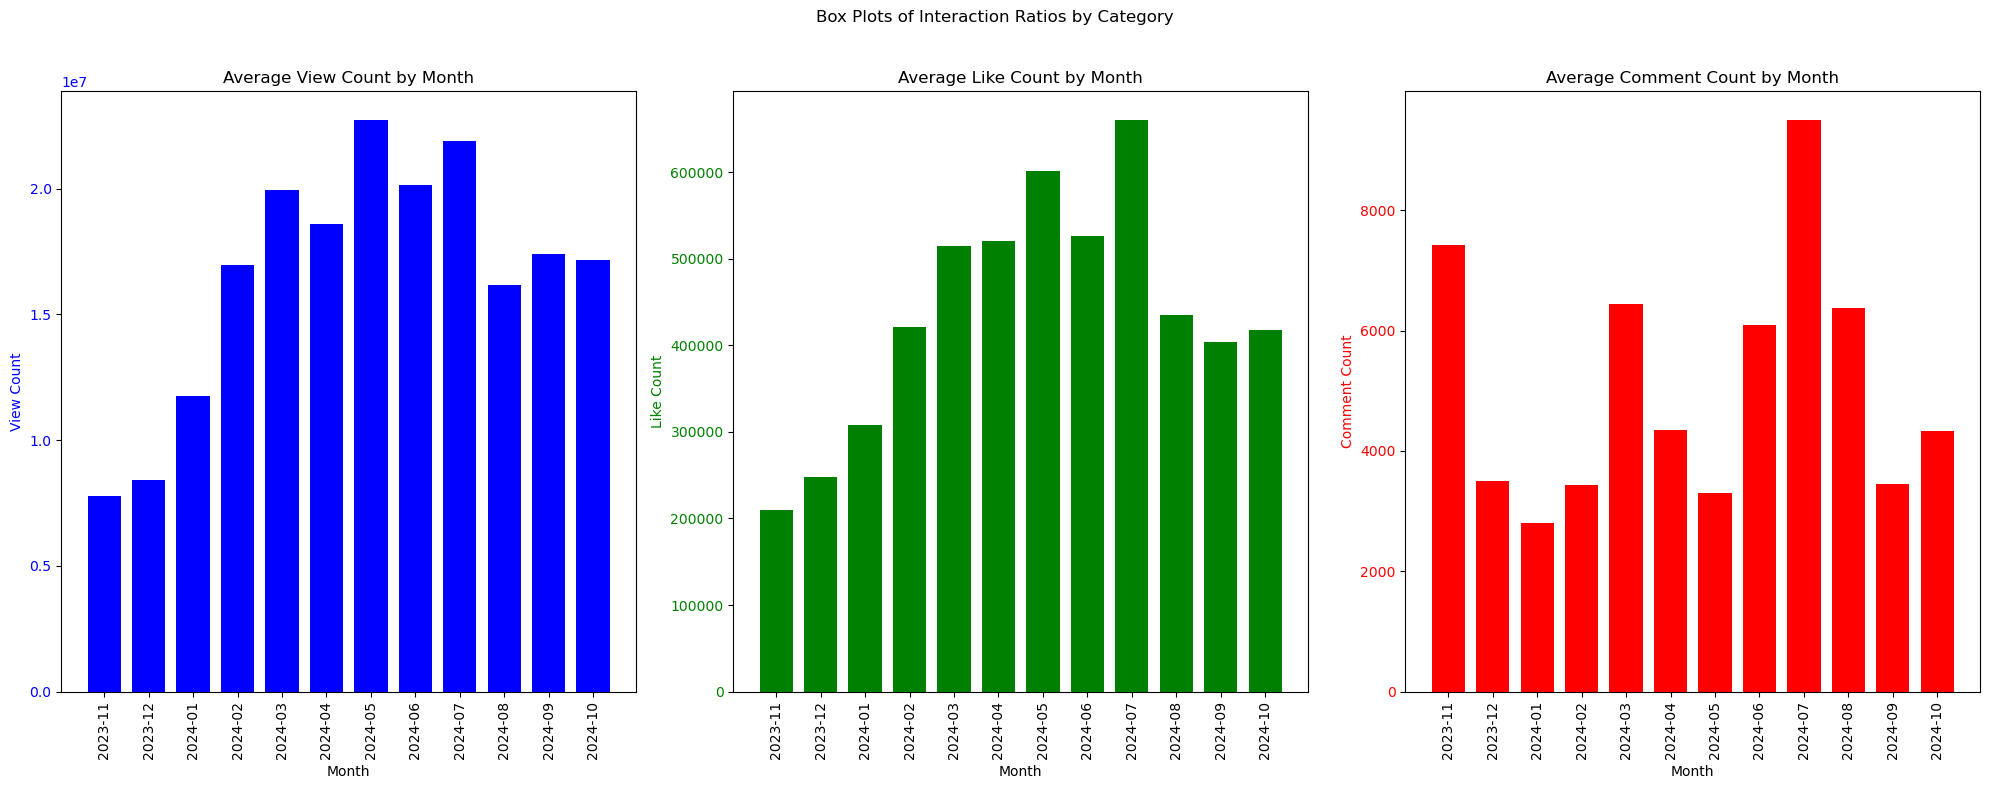

In [155]:
x = range(len(general_month['snapshot_date']))
width = 0.75
ig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

axes[0].bar(x, general_month['view_count'], width=width, label='View Count', color='b')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('View Count', color='b')
axes[0].set_xticks(x)
axes[0].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[0].tick_params(axis='y', labelcolor='b')
axes[0].set_title('Average View Count by Month')

axes[1].bar(x, general_month['like_count'], width=width, label='Like Count', color='g')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Like Count', color='g')
axes[1].set_xticks(x)
axes[1].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[1].tick_params(axis='y', labelcolor='g')
axes[1].set_title('Average Like Count by Month')

axes[2].bar(x, general_month['comment_count'], width=width, label='Comment Count', color='r')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Comment Count', color='r')
axes[2].set_xticks(x)
axes[2].set_xticklabels(general_month['snapshot_date'].astype(str), rotation=90)
axes[2].tick_params(axis='y', labelcolor='r')
axes[2].set_title('Average Comment Count by Month')

plt.suptitle('Box Plots of Interaction Ratios by Category')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()